In [ ]:
import os
import pandas as pd
import yfinance as yf

# -----------------------------
# 3 Industries × 10 Stocks Each
# -----------------------------

industries = {
    "technology": [
        'NVDA', 'AAPL', 'MSFT', 'GOOGL', 'AMZN',
        'META', 'AVGO', 'ORCL', 'AMD', 'INTC'
    ],
    "finance": [
        'JPM', 'BAC', 'WFC', 'C', 'GS',
        'MS', 'AXP', 'BLK', 'SCHW', 'SPGI'
    ],
    "healthcare": [
        'JNJ', 'PFE', 'UNH', 'MRK', 'ABBV',
        'TMO', 'DHR', 'LLY', 'BMY', 'AMGN'
    ]
}

start_date = "2010-01-01"
end_date   = None

output_dir = "/home/nckh2/qa/IntraFormer/data"
os.makedirs(output_dir, exist_ok=True)

total_count = 0

for industry, stocks in industries.items():
    print(f"\n=== Industry: {industry.upper()} ===")
    
    for symbol in stocks:
        total_count += 1
        print(f"\n[{total_count}/30] Fetching {symbol}...")
        
        df = yf.download(
            symbol,
            start=start_date,
            end=end_date,
            interval="1d",
            auto_adjust=True,
            progress=False
        )
        
        if df.empty:
            print(f"  No data for {symbol}")
            continue
        
        df = df[['Open','High','Low','Close','Volume']]
        df.columns = ['open','high','low','close','volume']
        
        file_path = os.path.join(output_dir, f"{symbol}_1d_full.csv")
        df.to_csv(file_path)
        
        print(f"  Saved {len(df):,} rows")
        print(f"  Range: {df.index.min().date()} → {df.index.max().date()}")
        print(f"  Latest close: {df['close'].iloc[-1]:,.2f} USD")

print("\nDone. Fetched up to 30 stocks across 3 industries.")

Visualizing results...

Saved: true_vs_pred_20260218.png


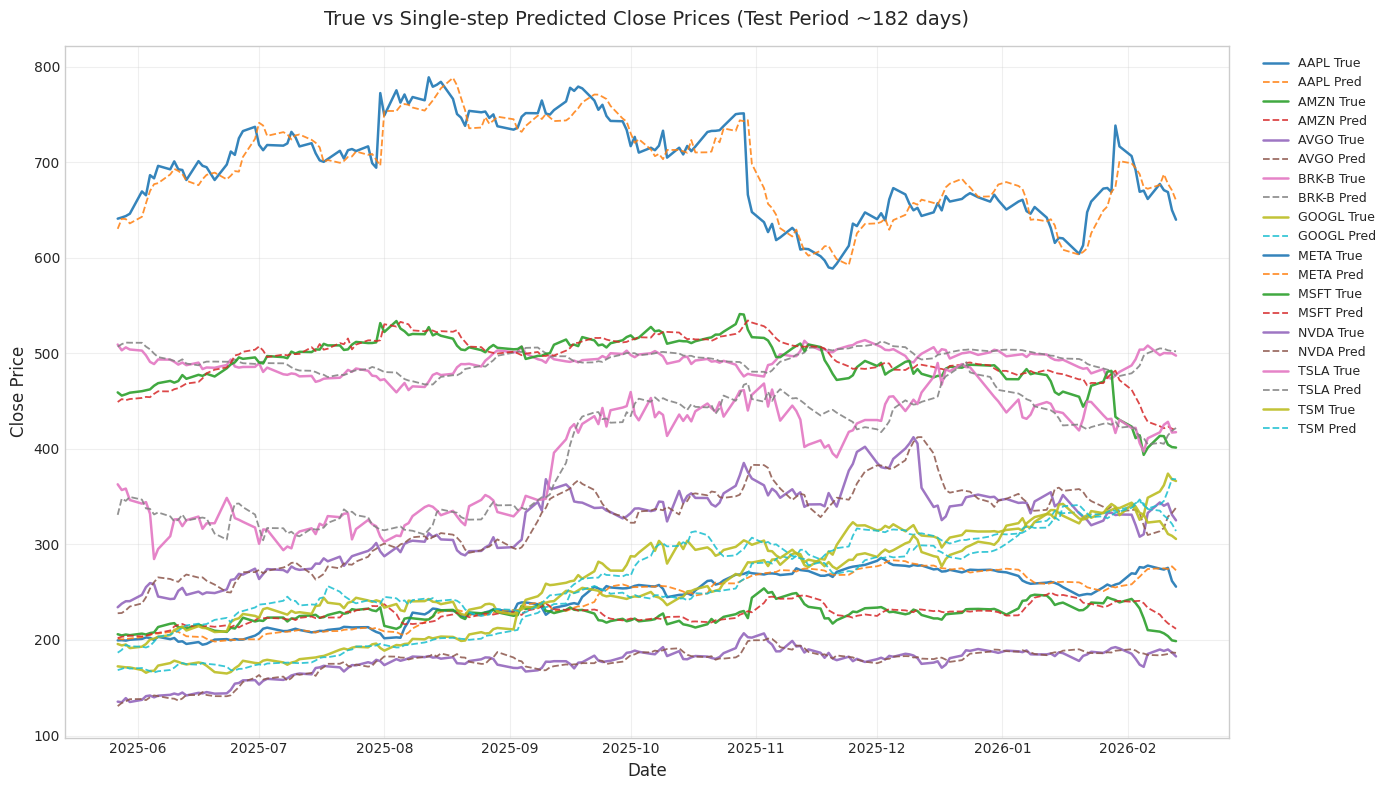

Saved: autoregressive_forecast_200days_20260218.png


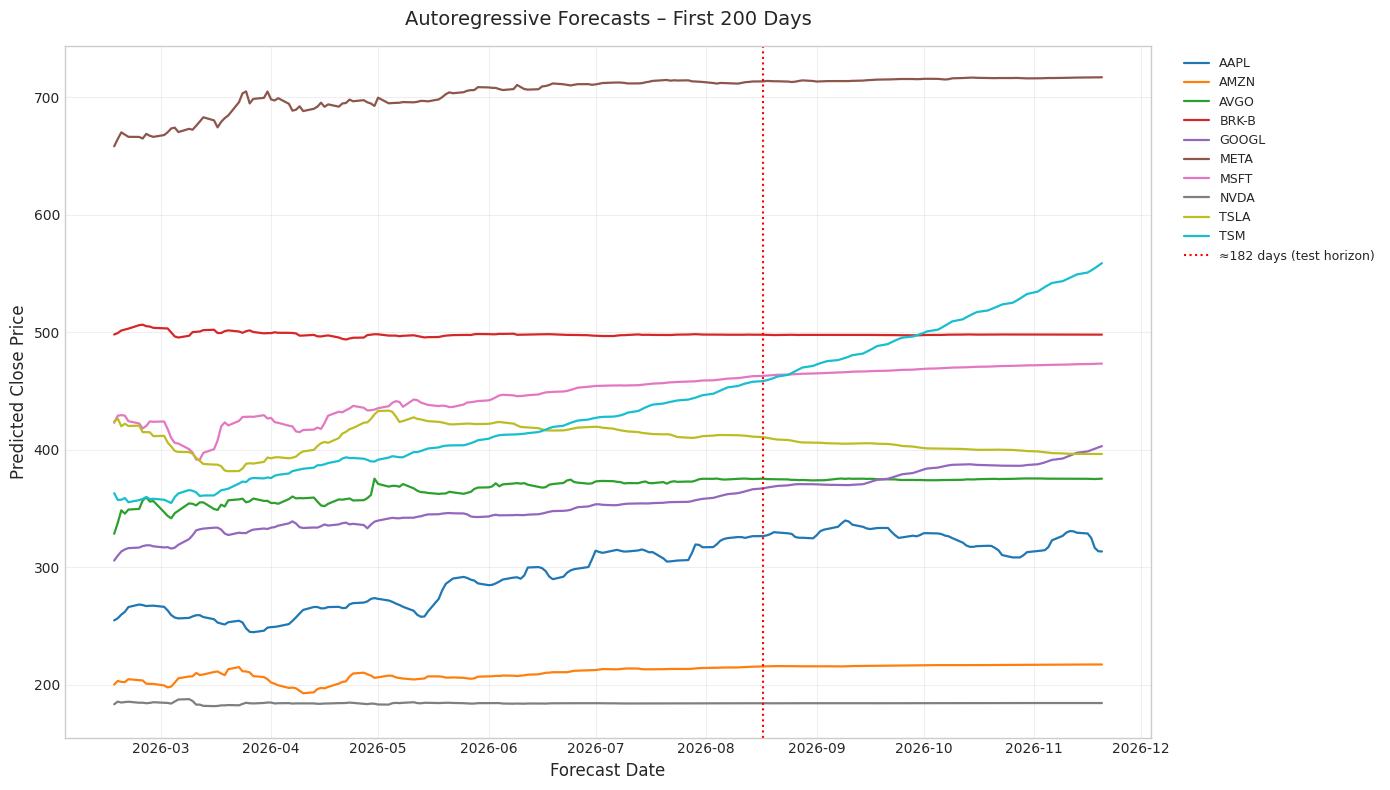


Single-step Test Metrics (~182-day hold-out)
symbol  test_days  rmse_real  mae_real  mape_pct
  AAPL        182     5.3064    4.0339      1.68
  AMZN        182     6.3092    4.7050      2.10
  AVGO        182    14.3845   10.6079      3.29
 BRK-B        182     6.1426    4.9614      1.01
 GOOGL        182     6.0528    4.5307      1.79
  META        182    17.8947   13.3979      1.93
  MSFT        182    11.4519    7.9231      1.68
  NVDA        182     4.8645    3.6885      2.10
  TSLA        182    16.2654   12.3271      3.20
   TSM        182     8.8802    7.3711      2.71



/tmp/ipykernel_530887/2530870426.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_display, x='symbol', y='mape_pct', palette='viridis')


Saved: mape_comparison_20260218.png


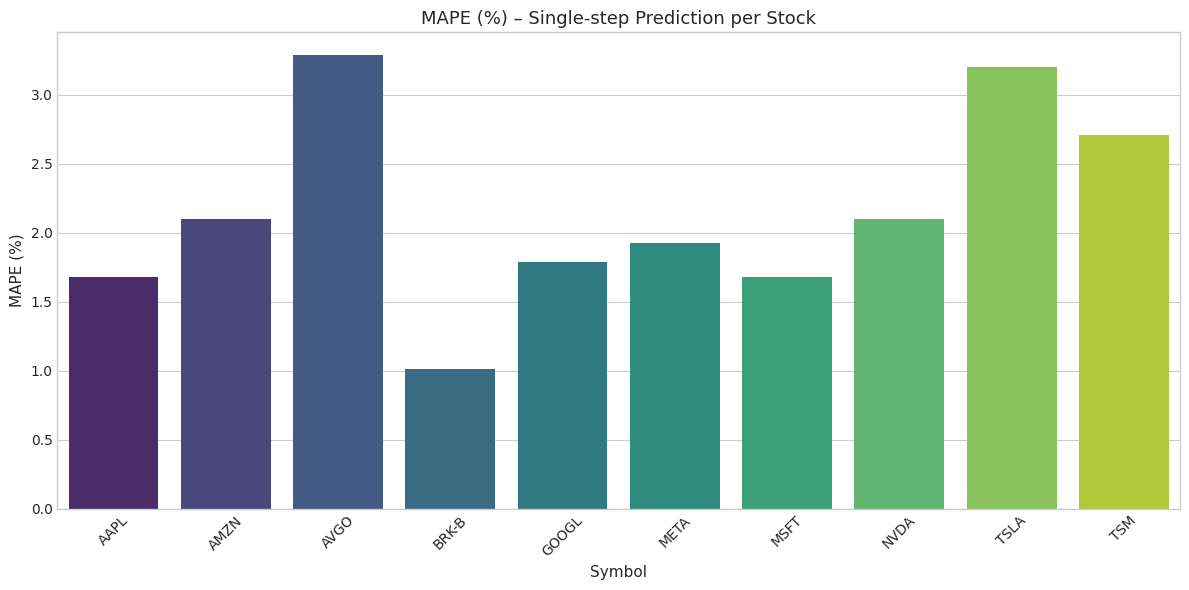


Done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ─── Configuration ───────────────────────────────────────────────────────────────
FILES = {
    'true_vs_pred':     "/home/nckh2/qa/all_stocks_true_vs_pred.csv",
    'autoregressive':   "/home/nckh2/qa/all_stocks_autoregressive_future.csv",
    'metrics':          "/home/nckh2/qa/all_stocks_metrics_split.csv",
}

SAVE_FIGURES = True
OUTPUT_DIR   = "/home/nckh2/qa/plots"
MAX_FORECAST_DAYS_TO_PLOT = 200   # ← changed: only show first 200 days of forecast

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

if SAVE_FIGURES:
    import os
    os.makedirs(OUTPUT_DIR, exist_ok=True)


def plot_true_vs_pred():
    df = pd.read_csv(FILES['true_vs_pred'])
    if df.empty:
        print("No data in true_vs_pred file")
        return

    df['date'] = pd.to_datetime(df['date'])
    symbols = sorted(df['symbol'].unique())
    
    plt.figure(figsize=(14, 8))
    
    for sym in symbols:
        sub = df[df['symbol'] == sym]
        if len(sub) < 5:
            continue
        plt.plot(sub['date'], sub['true_close'], 
                 label=f"{sym} True", linewidth=1.8, alpha=0.9)
        plt.plot(sub['date'], sub['pred_close_single_step'], 
                 label=f"{sym} Pred", linestyle='--', linewidth=1.3, alpha=0.85)
    
    plt.title("True vs Single-step Predicted Close Prices (Test Period ~182 days)", fontsize=14, pad=15)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if SAVE_FIGURES:
        today = datetime.now().strftime("%Y%m%d")
        plt.savefig(f"{OUTPUT_DIR}/true_vs_pred_{today}.png", dpi=300, bbox_inches='tight')
        print(f"Saved: true_vs_pred_{today}.png")
    plt.show()


def plot_autoregressive_forecast():
    df = pd.read_csv(FILES['autoregressive'])
    if df.empty:
        print("No data in autoregressive_future file")
        return

    df['date'] = pd.to_datetime(df['date'])
    symbols = sorted(df['symbol'].unique())
    
    plt.figure(figsize=(14, 8))
    
    for sym in symbols:
        sub = df[df['symbol'] == sym]
        # Limit to first N days
        sub = sub.iloc[:MAX_FORECAST_DAYS_TO_PLOT]
        if len(sub) < 10:
            continue
        plt.plot(sub['date'], sub['pred_close_autoregressive'], 
                 label=sym, linewidth=1.6)
    
    # Mark the 182-day point
    if not df.empty:
        start_date = df['date'].min()
        day182 = start_date + pd.Timedelta(days=182)
        plt.axvline(x=day182, color='red', linestyle=':', linewidth=1.5, 
                    label=f"≈182 days (test horizon)")
    
    plt.title(f"Autoregressive Forecasts – First {MAX_FORECAST_DAYS_TO_PLOT} Days", 
              fontsize=14, pad=15)
    plt.xlabel("Forecast Date", fontsize=12)
    plt.ylabel("Predicted Close Price", fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if SAVE_FIGURES:
        today = datetime.now().strftime("%Y%m%d")
        fname = f"{OUTPUT_DIR}/autoregressive_forecast_{MAX_FORECAST_DAYS_TO_PLOT}days_{today}.png"
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print(f"Saved: autoregressive_forecast_{MAX_FORECAST_DAYS_TO_PLOT}days_{today}.png")
    plt.show()


def show_metrics_table():
    df = pd.read_csv(FILES['metrics'])
    if df.empty:
        print("No data in metrics file")
        return

    display_cols = ['symbol', 'test_days', 'rmse_real', 'mae_real', 'mape_pct']
    df_display = df[display_cols].copy()
    df_display = df_display.round({'rmse_real': 4, 'mae_real': 4, 'mape_pct': 2})

    print("\n" + "="*80)
    print("Single-step Test Metrics (~182-day hold-out)")
    print("="*80)
    print(df_display.to_string(index=False))
    print("="*80 + "\n")

    # Bar plot for MAPE
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_display, x='symbol', y='mape_pct', palette='viridis')
    plt.title("MAPE (%) – Single-step Prediction per Stock", fontsize=13)
    plt.ylabel("MAPE (%)", fontsize=11)
    plt.xlabel("Symbol", fontsize=11)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if SAVE_FIGURES:
        today = datetime.now().strftime("%Y%m%d")
        plt.savefig(f"{OUTPUT_DIR}/mape_comparison_{today}.png", dpi=300, bbox_inches='tight')
        print(f"Saved: mape_comparison_{today}.png")
    plt.show()


if __name__ == "__main__":
    print("Visualizing results...\n")
    
    plot_true_vs_pred()
    plot_autoregressive_forecast()
    show_metrics_table()
    
    print("\nDone.")

In [ ]:
import os
import pandas as pd
import yfinance as yf

# -----------------------------
# 3 Industries × 10 Stocks Each
# -----------------------------

industries = {
    "technology": [
        'NVDA', 'AAPL', 'MSFT', 'GOOGL', 'AMZN',
        'META', 'AVGO', 'ORCL', 'AMD', 'INTC'
    ],
    "finance": [
        'JPM', 'BAC', 'WFC', 'C', 'GS',
        'MS', 'AXP', 'BLK', 'SCHW', 'SPGI'
    ],
    "healthcare": [
        'JNJ', 'PFE', 'UNH', 'MRK', 'ABBV',
        'TMO', 'DHR', 'LLY', 'BMY', 'AMGN'
    ]
}

start_date = "2010-01-01"
end_date   = None

output_dir = "/home/nckh2/qa/Quantum/data"
os.makedirs(output_dir, exist_ok=True)

total_count = 0

for industry, stocks in industries.items():
    print(f"\n=== Industry: {industry.upper()} ===")
    
    for symbol in stocks:
        total_count += 1
        print(f"\n[{total_count}/30] Fetching {symbol}...")
        
        df = yf.download(
            symbol,
            start=start_date,
            end=end_date,
            interval="1d",
            auto_adjust=True,
            progress=False
        )
        
        if df.empty:
            print(f"  No data for {symbol}")
            continue
        
        df = df[['Open','High','Low','Close','Volume']]
        df.columns = ['open','high','low','close','volume']
        
        file_path = os.path.join(output_dir, f"{symbol}_1d_full.csv")
        df.to_csv(file_path)
        
        print(f"  Saved {len(df):,} rows")
        print(f"  Range: {df.index.min().date()} → {df.index.max().date()}")
        print(f"  Latest close: {df['close'].iloc[-1]:,.2f} USD")

print("\nDone. Fetched up to 30 stocks across 3 industries.")